In [1]:
pip install hmmlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 kB 3.7 MB/s eta 0:00:00


In [2]:
from hmmlearn.hmm import GaussianHMM
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import requests

## 1. Données et univers d’investissement



Dans cette première partie, on construit l’univers sur lequel on va tester les stratégies HMM.

- **Core** : l’ETF `SPY`, qui représente le S&P 500.  
  → C’est notre exposition “de base” au marché actions US.

- **Satellite** : une sélection d’actions américaines   
  → Elles serviront plus tard pour l’overlay directionnel en fonction des régimes HMM.

L’idée est donc de travailler dans une logique **core–satellite** :
SPY reste le socle du portefeuille, et les actions individuelles servent à sur-pondérer
ou sous-pondérer certains titres en fonction du régime de marché.

Nous téléchargeons ensuite les prix historiques sur la période :

- du **01/01/2000** au **31/12/2025**,
- et nous construisons des **rendements log quotidiens**, qui seront utilisés
par le HMM.


In [3]:
url = "https://en.wikipedia.org/wiki/S%26P_100"
headers = {"User-Agent": "Mozilla/5.0"}

html = requests.get(url, headers=headers).text
tables = pd.read_html(html)
df = tables[2].copy()
df["Ticker"] = df["Symbol"].astype(str)
df["Ticker"] = df["Ticker"].str.replace(".", "-", regex=False)
tickers_sat= df["Ticker"].tolist()


/tmp/ipython-input-3206719617.py:5: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(html)


In [4]:
# =========================
# 1. Définition de l'univers
# =========================

tickers_core = ["SPY"]   # Core : ETF S&P 500

tickers_all = tickers_core + tickers_sat

# =========================
# 2. Data Loading
# =========================

start = "2000-01-01"
end   = "2025-12-31"

data_px = yf.download(tickers_all, start=start, end=end)["Close"]

# Séparation core / satellite
spy_price     = data_px["SPY"]
prices_stocks = data_px[tickers_sat]

# ===================================
# 3. Rendements log
# ==================================

# Rendements log quotidiens
returns_spy    = np.log(spy_price / spy_price.shift(1)).dropna()
returns_stocks = np.log(prices_stocks / prices_stocks.shift(1))

# Alignement des dates
returns_stocks = returns_stocks.loc[returns_spy.index]
spy_price      = spy_price.loc[returns_spy.index]
prices_stocks  = prices_stocks.loc[returns_spy.index]


/tmp/ipython-input-2637505666.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data_px = yf.download(tickers_all, start=start, end=end)["Close"]
[*********************100%***********************]  102 of 102 completed


## 2. Estimation « in-sample »


Dans ce premier backtest, on se met dans un cadre optimiste **in-sample** :

- le HMM est entraîné **une seule fois** sur l’ensemble de l’historique,
- les régimes Bull / Bear / Neutre sont connus pour toutes les dates,
- on construit un signal d’exposition sur SPY en fonction de ces régimes

### 2.1. Fit du modèle :



Avant de passer au backtest, on commence par estimer un **HMM à 2 états** uniquement
sur les rendements du SPY :

- un état à **moyenne faible / négative** → régime **Bear** ;
- un état à **moyenne plus élevée** → régime **Bull**.

Ici, le HMM est entraîné **une seule fois** sur toute l’histoire (2000–2025).
Ce modèle joue le rôle de **référence in-sample** (le « professeur ») :
il suppose implicitement que la structure statistique du marché est stable sur tout
l’échantillon.

Les étapes sont :

1. Construire la matrice `X` des rendements du SPY (colonne unique).
2. Estimer un `GaussianHMM` à 2 composantes :
   - chaque état génère des rendements ~ Normal(µ_k, Σ_k),
   - la dynamique des états suit une chaîne de Markov.
3. Récupérer les **moyennes des 2 états**, et les trier pour imposer une convention :
   - état 0 = **Bear** (µ plus faible),
   - état 1 = **Bull** (µ plus élevé).
4. Calculer, pour chaque date, les **probabilités filtrées** :
   - P(Bear | données),
   - P(Bull | données).
5. Transformer ces probabilités en **labels de régime** via un seuil :
   - si P(Bull) > `threshold` → régime = *bull* ;
   - si P(Bear) > `threshold` → régime = *bear* ;
   - sinon → régime = *neutral*.

Le paramètre `threshold` (ici 0.6) permet de laisser une zone « grise » où le modèle
n’est pas assez confiant pour trancher → on crée alors un régime *neutral*.

> ⚠️ `hmmlearn` affiche parfois un warning de non-convergence du log-vraisemblance.
> Ici la différence est très faible, donc on l’accepte ; si besoin, on pourrait
> augmenter `n_iter` ou changer de `random_state`.


In [5]:
threshold = 0.7  # seuil de confiance pour appeler un régime Bull / Bear

# =========================
# 2.1 Calibration du HMM « full sample »
# =========================

# X : matrice (T, 1) des rendements du SPY
X = returns_spy.values.reshape(-1, 1)

# HMM gaussien à 2 états (on suppose des rendements ~ Normal par régime)
model = GaussianHMM(
    n_components=2,
    covariance_type="full",
    n_iter=200,
    random_state=0
)
model.fit(X)

# -------------------------
# Probabilités d'appartenir à chaque état (filtrage)
# proba[t, k] = P(état = k | données jusqu'à t)
# shape = (T, 2)
# -------------------------
proba = model.predict_proba(X)

# -------------------------
# Identification des états Bull / Bear
# -------------------------
means = model.means_.ravel()          # moyennes mu_0, mu_1
order = np.argsort(means)             # tri des états par moyenne croissante
# -> après tri : index 0 = état "bear" (mu plus bas), 1 = "bull"

means_full_ord = means[order]
mu_bear_full = means_full_ord[0]
mu_bull_full = means_full_ord[1]

# On réordonne aussi les probabilités pour que :
# colonne 0 = Bear, colonne 1 = Bull
proba = proba[:, order]

proba_bear_spy = proba[:, 0]
proba_bull_spy = proba[:, 1]

# On remet les proba dans des Series alignées sur les dates
proba_bull_s = pd.Series(proba_bull_spy, index=returns_spy.index)
proba_bear_s = pd.Series(proba_bear_spy, index=returns_spy.index)

# -------------------------
# Transformation en régimes discrets avec seuil
# -------------------------
regime = pd.Series("neutral", index=returns_spy.index, dtype=object)

# si P(Bull) > threshold -> bull
regime[proba_bull_s > threshold] = "bull"

# si P(Bear) > threshold -> bear
regime[proba_bear_s > threshold] = "bear"

regime.head()


,0
Date,
2000-01-04,bear
2000-01-05,bear
2000-01-06,bear
2000-01-07,bear
2000-01-10,bear


### 2.2. Scoring des actions

#### Moyennes empiriques


Pour savoir quelles actions sur/sous-pondérer dans chaque régime,
on calcule, sur la fenêtre de training, un **score cyclique** pour chaque titre :

1. On identifie, sur l’historique utilisé pour entraîner le HMM,
   les jours où le régime du SPY est Bull et les jours où il est Bear.
2. Pour chaque action \( i \), on calcule :
   - $ \mu_i^{\text{bull}} $= moyenne des rendements de l’action pendant les jours Bull,
   - $\mu_i^{\text{bear}} \$= moyenne des rendements de l’action pendant les jours Bear.

3. On définit un score :
   $$
   \text{score}_i = \max\big( \mu_i^{\text{bull}} - \mu_i^{\text{bear}}, 0 \big)
   \$$
   - si ce score est positif, l’action a tendance à mieux se comporter en Bull qu’en Bear,
   - s’il est nul, on ne lui attribue pas de rôle “cyclique”.

4. On normalise ensuite ces scores pour obtenir un vecteur de poids relatif :
   $$
   w_i^{\text{rel}} = \frac{\text{score}_i}{\sum_j \text{score}_j}
   $$



utiliser esperance ( pour prendre en compte les proba with moyennes) - diviser  par std, var par asset = cov diagonale


In [6]:
# Alignement
idx = returns_spy.index
returns_stocks = returns_stocks.loc[idx]

bull_mask = (regime == "bull")
bear_mask = (regime == "bear")

# Moyenne des rendements des actions dans chaque régime
mu_bull = returns_stocks[bull_mask].mean()
mu_bear = returns_stocks[bear_mask].mean()

# Score = sensibilité au cycle
off_score = (mu_bull - mu_bear)

# Les scores positifs
off_score = off_score.clip(lower=0)

# Normalisation ==> poids
off_norm = off_score / off_score.sum()


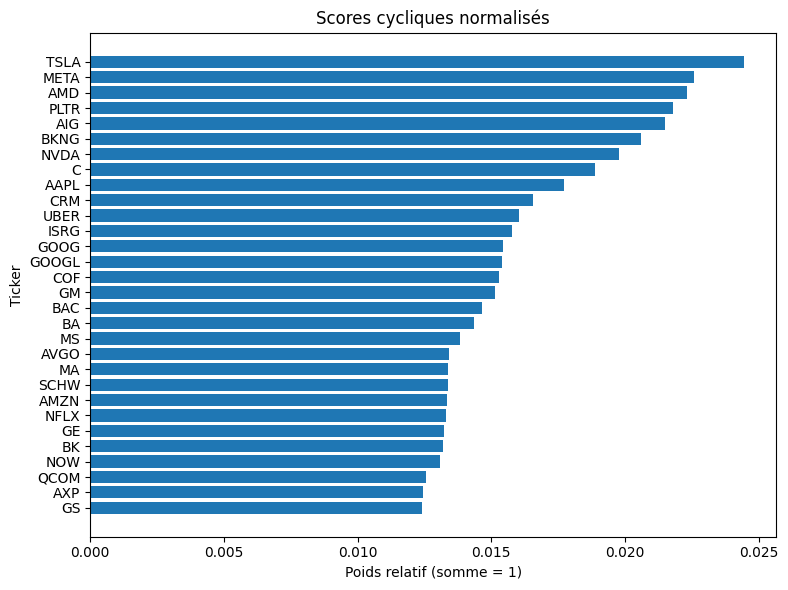

In [7]:

# Tri décroissant
scores = off_norm.sort_values(ascending=False)
def plot_scores(scores):
  plt.figure(figsize=(8, 6))
  plt.barh(scores.index, scores.values)
  plt.gca().invert_yaxis()   # pour avoir le plus grand en haut

  plt.title("Scores cycliques normalisés")
  plt.xlabel("Poids relatif (somme = 1)")
  plt.ylabel("Ticker")

  plt.tight_layout()
  plt.show()

plot_scores(scores.head(30))

#### Espérances

On exploite les **probabilités de régime** fournies par le HMM, plutôt qu’un
classement Bull / Bear binaire. Pour chaque date \(t\) :

- $p_t^{\text{bull}}$ = probabilité d’être en régime Bull,
- $p_t^{\text{bear}}$ = probabilité d’être en régime Bear.

Les espérances conditionnelles sont estimées par :

$$
\mu_i^{\text{bull}} =
\frac{\sum_t p_t^{\text{bull}} R_{i,t}}{\sum_t p_t^{\text{bull}}}, \qquad
\mu_i^{\text{bear}} =
\frac{\sum_t p_t^{\text{bear}} R_{i,t}}{\sum_t p_t^{\text{bear}}}.
$$

Score cyclique « soft » :
$$
\text{score}_i^{(2)} = \max\big( \mu_i^{\text{bull}} - \mu_i^{\text{bear}},\, 0 \big)
$$

In [8]:
# Probabilités de régime (séries alignées avec les rendements)
pbull = proba_bull_s.reindex(returns_stocks.index)
pbear = proba_bear_s.reindex(returns_stocks.index)

# Rendements des actions
R = returns_stocks.loc[returns_spy.index]

# Espérance conditionnelle
# numérateur : somme_t p_t^regime * R_{i,t}
mu_bull_soft = (pbull.values.reshape(-1, 1) * R).sum(axis=0) / pbull.sum()
mu_bear_soft = (pbear.values.reshape(-1, 1) * R).sum(axis=0) / pbear.sum()

# Score cyclique
off_score_2= (mu_bull_soft - mu_bear_soft).clip(lower=0.0)

# Normalisation en poids
off_norm_2= off_score_2 / off_score_2.sum()


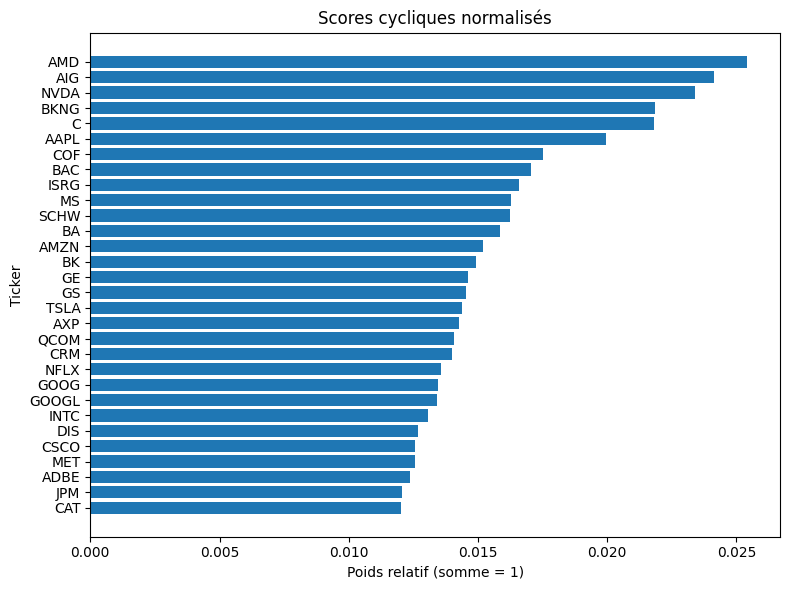

In [9]:
plot_scores(off_norm_2.sort_values(ascending=False).head(30))

#### Ajustement des espérances au risque



On conserve la logique d’espérance conditionnelle pondérée par les
probabilités de régime fournies par le HMM :

$$
\mu_i^{\text{bull}}
= \frac{\sum_t p_t^{\text{bull}} R_{i,t}}{\sum_t p_t^{\text{bull}}}, \quad
\mu_i^{\text{bear}}
= \frac{\sum_t p_t^{\text{bear}} R_{i,t}}{\sum_t p_t^{\text{bear}}}.
$$

La surperformance cyclique de l’action \(i\) est définie par
\(\Delta \mu_i = \mu_i^{\text{bull}} - \mu_i^{\text{bear}}\).

Pour intégrer le risque spécifique du titre, cette surperformance
est ensuite divisée par la volatilité totale du titre, \(\sigma_i\),
ce qui conduit au score :

$$
\text{score}_i = \max\left( \frac{\Delta \mu_i}{\sigma_i}, 0 \right).
$$

Après normalisation de ces scores, on obtient un vecteur de poids
relatifs utilisé pour construire l’overlay actions. Ce critère
combine donc :

- l’information probabiliste du HMM (via les proba de régimes),
- l’espérance de rendement par régime,
- et un ajustement par la volatilité du titre.


In [10]:
eps= 0.0001
delta_mu = mu_bull_soft - mu_bear_soft

# --- Volatilité du titre (sur toute la fenêtre) ---

sigma = R.std()

# --- Score = espérance probabilisée / vol ---

off_score_3 = delta_mu / (sigma + eps)    # ratio rendement / risque
off_score_3= off_score_3.clip(lower=0.0)

# Normalisation en poids
off_norm_3= off_score_3 / off_score_3.sum()



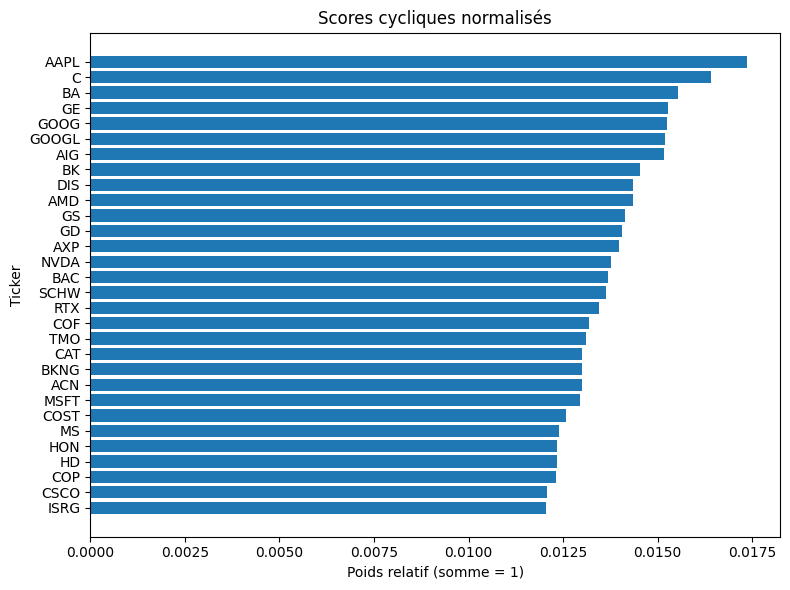

In [11]:
plot_scores(off_norm_3.sort_values(ascending=False).head(30))

#### Synthèse

In [12]:
# Regroupement des 3 séries
df= pd.DataFrame({
    'Moyenne empirique': off_norm,
    'Espérance': off_norm_2,
    'Espérance ajustée au risque': off_norm_3
})

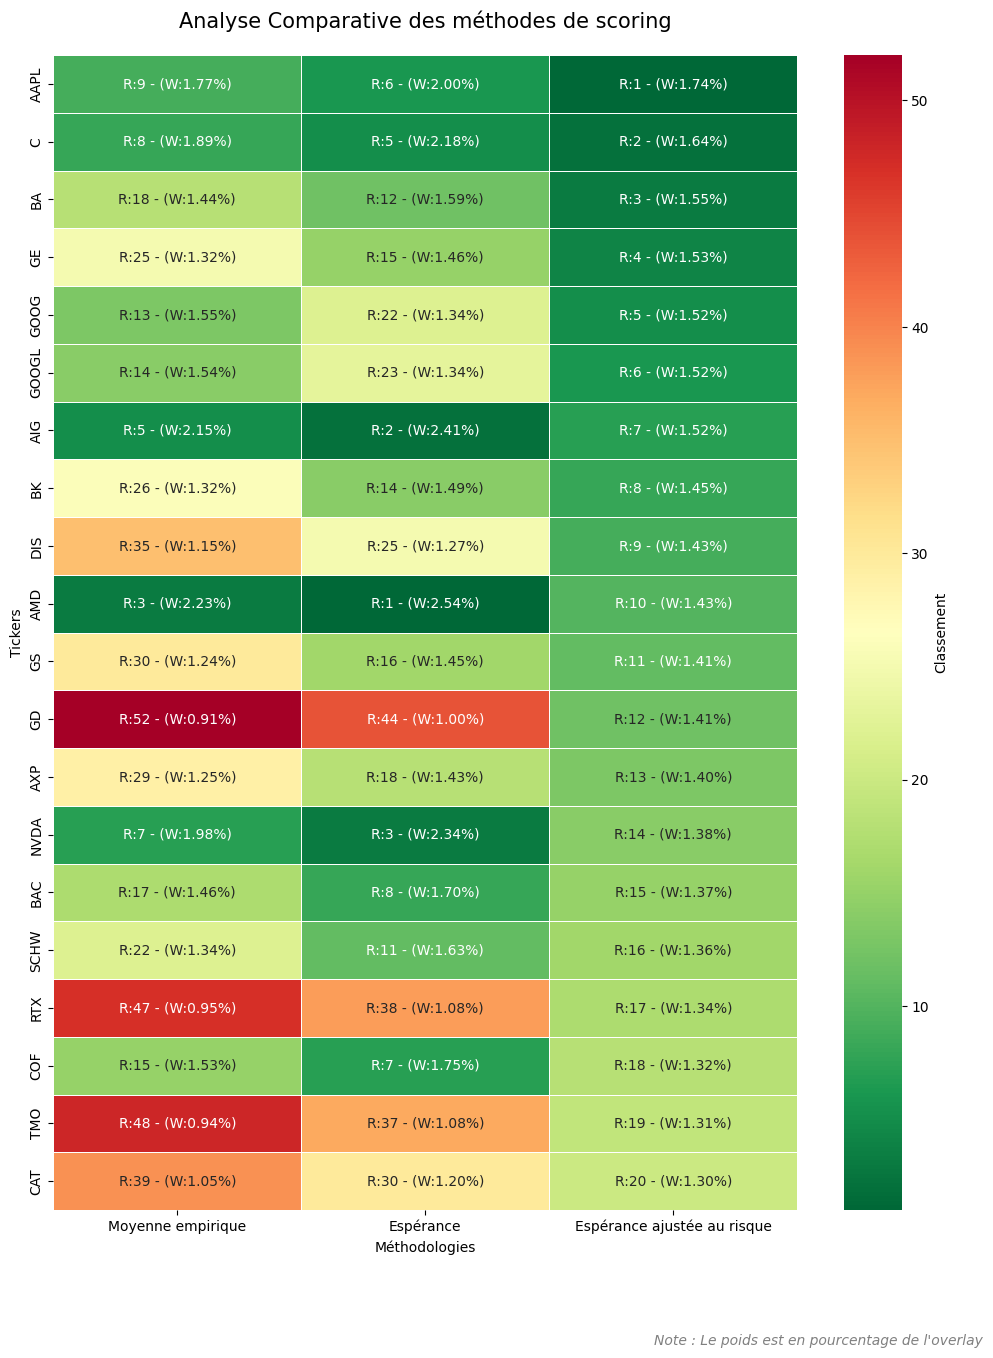

In [13]:

# Calcul des rangs
df_ranks = df.rank(ascending=False)

annot_matrix = []
for i in range(len(df)):
    row = []
    for j in range(len(df.columns)):
        val = df.iloc[i, j]
        rank = int(df_ranks.iloc[i, j])
        # Format : Valeur brute (4 décimales) sur une ligne, Rang en dessous
        row.append(f"R:{rank} - (W:{val*100:.2f}%)")
    annot_matrix.append(row)

# Tri par la colonne des Ajustées au Risque
df_sorted = df.sort_values('Espérance ajustée au risque', ascending=False)
df_ranks_plot = df_ranks.loc[df_sorted.index]
# On réaligne la matrice d'annotation sur le nouvel ordre
annot_plot = np.array(annot_matrix)[df.index.get_indexer(df_sorted.index)]

# 4. Affichage
plt.figure(figsize=(12, 15))
sns.heatmap(df_ranks_plot.head(20),
            annot=annot_plot[:20],
            fmt="",
            cmap="RdYlGn_r",
            linewidths=0.7,
            cbar_kws={'label': 'Classement'})

plt.title("Analyse Comparative des méthodes de scoring", fontsize=15, pad=20)
plt.ylabel("Tickers")
plt.xlabel("Méthodologies")
# Place le texte en bas à droite du graphique
plt.figtext(0.9, 0.02, "Note : Le poids est en pourcentage de l'overlay",
            horizontalalignment='right', fontsize=10, style='italic', color='gray')
plt.show()

### 2.3. Strategie de trading



Objectifs:

- visualiser les régimes détectés par le HMM,
- comprendre comment la stratégie réagit aux phases de marché,
- obtenir un benchmark de performance “idéal” avant d’introduire des contraintes
  plus réalistes.


#### Metrics de comparaison

In [14]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def analyzeVSbench(
    returns_strat, returns_bench, signal=None, regimes=None,
    freq=252, window_rolling=63, title="Analyse stratégie vs Buy & Hold"
):
    # --- 0) Alignement et Calculs ---
    df = pd.DataFrame({"ret_strat": returns_strat, "ret_bench": returns_bench}).dropna()
    df["signal"] = signal.reindex(df.index) if signal is not None else 1.0

    if regimes is not None:
        reg = regimes.reindex(df.index).ffill().fillna("neutral")
        reg_map = {"bear": -1, "neutral": 0, "bull": 1}
        df["regime_num"] = reg.map(reg_map)

    df.index = pd.to_datetime(df.index)
    df["equity_strat"] = 100 * (1 + df["ret_strat"]).cumprod()
    df["equity_bench"] = 100 * (1 + df["ret_bench"]).cumprod()

    def drawdown(equity):
        return equity / equity.cummax() - 1.0

    df["dd_strat"] = drawdown(df["equity_strat"])
    df["dd_bench"] = drawdown(df["equity_bench"])

    roll = df["ret_strat"].rolling(window_rolling)
    df["roll_vol"] = roll.std() * np.sqrt(freq)
    df["roll_expo"] = df["signal"].abs().rolling(window_rolling).mean()

    # --- Metrics pour le Tableau ---
    def calc_metrics(rets, dd, equity):
        cagr = (equity.iloc[-1] / equity.iloc[0]) ** (freq / len(rets)) - 1
        vol = rets.std() * np.sqrt(freq)
        sharpe = (rets.mean() * freq) / vol if vol != 0 else 0
        return [f"{cagr:.2%}", f"{vol:.2%}", f"{sharpe:.2f}", f"{dd.min():.2%}", f"{(equity.iloc[-1]/100 - 1):.2%}"]

    metrics_names = ["CAGR", "Volatilité", "Sharpe", "Max Drawdown", "Performance Totale"]
    stats_strat = calc_metrics(df["ret_strat"], df["dd_strat"], df["equity_strat"])
    stats_bench = calc_metrics(df["ret_bench"], df["dd_bench"], df["equity_bench"])

    # --- 1) Création du Figure ---
    fig = make_subplots(
        rows=6, cols=1,
        shared_xaxes=True,
        vertical_spacing=0.04,

        row_heights=[0.18, 0.32, 0.10, 0.10, 0.10, 0.10],
        specs=[[{"type": "table"}], [{"type": "scatter"}], [{"type": "scatter"}],
               [{"type": "scatter"}], [{"type": "scatter"}], [{"type": "scatter"}]],
        subplot_titles=(
            "",
            "<b>Performance Cumulative</b> (Base 100 - Log Scale)",
            "<b>Drawdown</b>",
            f"<b>Volatilité Mobile ({window_rolling} j)</b>",
            f"<b>Exposition Moyenne ({window_rolling} j)</b>",
            "<b>Régimes HMM</b>"
        )
    )

    # --- TABLEAU DE METRICS ---
    fig.add_trace(go.Table(
        header=dict(
            values=["<b>Métrique</b>", "<b>Stratégie</b>", "<b>Benchmark (B&H)</b>"],
            fill_color='#2c3e50',
            align='center',
            font=dict(color='white', size=13),
            height=30
        ),
        cells=dict(
            values=[metrics_names, stats_strat, stats_bench],
            fill_color=[['#fdfdfe']*5, ['#e3f2fd']*5, ['#f1f1f1']*5],
            align='center',
            font=dict(color='#2c3e50', size=12),
            height=28
        )
    ), row=1, col=1)

    x = df.index

    # 1) Equity (Log Scale)
    fig.add_trace(go.Scatter(x=x, y=df["equity_bench"], name="Benchmark",
                             line=dict(color='#7f8c8d', width=2.5)), row=2, col=1)
    fig.add_trace(go.Scatter(x=x, y=df["equity_strat"], name="Stratégie",
                             line=dict(color='#1f77b4', width=2.5)), row=2, col=1)

    # 2) Drawdown
    fig.add_trace(go.Scatter(x=x, y=df["dd_bench"], name="DD Bench", fill='tozeroy',
                             line=dict(width=0), fillcolor='rgba(127, 140, 141, 0.4)'), row=3, col=1)
    fig.add_trace(go.Scatter(x=x, y=df["dd_strat"], name="DD Strat", fill='tozeroy',
                             line=dict(width=0), fillcolor='rgba(231, 76, 60, 0.4)'), row=3, col=1)

    # 3) Vol mobile
    fig.add_trace(go.Scatter(x=x, y=df["roll_vol"], name="Vol mobile", line=dict(color='#f39c12', width=1.5)), row=4, col=1)

    # 4) Expo
    fig.add_trace(go.Scatter(x=x, y=df["roll_expo"], name="Expo Moyenne", line=dict(color='#9b59b6', width=1.5)), row=5, col=1)

    # 5) Régimes
    if "regime_num" in df.columns:
        fig.add_trace(go.Scatter(x=x, y=df["regime_num"], mode="lines",
                                 line=dict(color='#34495e', width=1.5, shape="hv"), name="Régime"), row=6, col=1)

    # --- Layout & Esthétique ---
    fig.update_layout(
        height=1400,
        title=dict(text=f"<b>{title}</b>", x=0.5, y=0.98, font=dict(size=22)),
        template="plotly_white",
        hovermode="x unified",

        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=0.78,
            xanchor="center",
            x=0.5
        ),
        margin=dict(t=120, b=50, l=50, r=50)
    )

    fig.update_yaxes(type="log", title_text="Equity", row=2, col=1)
    fig.update_yaxes(title_text="DD (%)", tickformat=".1%", row=3, col=1)
    fig.update_yaxes(title_text="Vol (%)", tickformat=".1%", row=4, col=1)
    fig.update_yaxes(title_text="Expo", row=5, col=1)
    fig.update_yaxes(title_text="Régime", row=6, col=1)

    fig.show()
    return df

#### Périodes de visualisation


| Période | Dates Clés | Contexte de Marché | Objectif d'Analyse |
| :--- | :--- | :--- | :--- |
| **Crise Financière (GFC)** | 2007 - 2009 | Crise des Subprimes (Bear Market) | Vérifier la réduction du **Max Drawdown** (-42% strat vs -55% bench) |
| **Expansion Post-Crise** | 2010 - 2019 | Bull Market séculaire (Low Vol) | Observer si l'overlay ne crée pas de "drag" (traîne) sur la performance du SPY. |
| **Choc COVID-19** | 2020 (Q1-Q2) | Krach éclair et rebond massif | Tester la réactivité du modèle aux changements brutaux de régime HMM. |
| **Relance & Euphorie** | 2020 - 2021 | Liquidités abondantes et forte croissance | Analyser la capture de tendance lors d'une hausse parabolique. |
| **Bear Market Inflation** | 2022 | Remontée des taux (Bear Market) | Évaluer l'efficacité de la composante **"Bear Short"** de l'overlay. |
| **Cycle IA & Actuel** | 2023 - 2025 | Concentration Tech (Post-COVID) | Valider la robustesse actuelle avec les derniers poids (AAPL, NVDA, GOOGL). |

In [90]:
# 1) Définition des périodes cibles
analysis_periods = {
    "Crise Financière 2008": ('2007-01-01', '2009-12-31'),
    "Bear Market Inflation 2022": ('2022-01-01', '2022-12-31'),
    "Cycle IA actuel (2023-2025)": ('2023-01-01', '2025-12-31'),
    "Krach & Rebond COVID": ('2020-01-01', '2020-12-31'),
    "TEST" : ('2023-01-01', '2025-12-31')  #Fenêtre de TEST
}

#### Backtest in sample

In [16]:
ACTIVE_BULL = 0.30
ACTIVE_BEAR = 0.30

In [17]:
tickers = returns_stocks.columns
scores = off_norm_3.reindex(tickers)
scores.name = "score"

weights_overlay = pd.DataFrame(
    0.0, index=idx, columns=tickers
)

for t in idx:
    reg = regime.loc[t]

    if reg == "bull":
        # long-only sur les cycliques
        weights_overlay.loc[t] = ACTIVE_BULL * scores

    elif reg == "bear":
        # short sur les cycliques → underweight vs SPY
        weights_overlay.loc[t] = -ACTIVE_BEAR * scores

    else:
        # neutral → overlay = 0
        pass

weights_overlay.tail()


Ticker,AAPL,ABBV,ABT,ACN,ADBE,AIG,AMD,AMGN,AMT,AMZN,...,UBER,UNH,UNP,UPS,USB,V,VZ,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2025-12-23,0.005209,0.001508,0.002877,0.0039,0.003039,0.004547,0.004304,0.001738,0.001712,0.003269,...,0.000829,0.001641,0.002869,0.002675,0.003574,0.002586,0.00173,0.00331,0.0017,0.002769
2025-12-24,0.005209,0.001508,0.002877,0.0039,0.003039,0.004547,0.004304,0.001738,0.001712,0.003269,...,0.000829,0.001641,0.002869,0.002675,0.003574,0.002586,0.00173,0.00331,0.0017,0.002769
2025-12-26,0.005209,0.001508,0.002877,0.0039,0.003039,0.004547,0.004304,0.001738,0.001712,0.003269,...,0.000829,0.001641,0.002869,0.002675,0.003574,0.002586,0.00173,0.00331,0.0017,0.002769
2025-12-29,0.005209,0.001508,0.002877,0.0039,0.003039,0.004547,0.004304,0.001738,0.001712,0.003269,...,0.000829,0.001641,0.002869,0.002675,0.003574,0.002586,0.00173,0.00331,0.0017,0.002769
2025-12-30,0.005209,0.001508,0.002877,0.0039,0.003039,0.004547,0.004304,0.001738,0.001712,0.003269,...,0.000829,0.001641,0.002869,0.002675,0.003574,0.002586,0.00173,0.00331,0.0017,0.002769


In [18]:
# Core SPY
ret_core = returns_spy.copy()
ret_core.name = "ret_core"

# Overlay : somme_i w_i(t-1) * r_i(t)
ret_overlay = (weights_overlay.shift(1) * returns_stocks).sum(axis=1)
ret_overlay.name = "ret_overlay"

# Rendement total de la stratégie
ret_total = ret_core + ret_overlay
ret_total.name = "ret_total_core_satellite"

# Exposition nette approximative
net_exposure = 1.0 + weights_overlay.sum(axis=1)
net_exposure.name = "net_exposure"


# On applique cette expo à SPY (expo décidée à t-1, appliquée sur r_SPY(t))
lev_shift = net_exposure.shift(1).fillna(1.0)
ret_spy_levered = lev_shift * returns_spy
ret_spy_levered.name = "ret_spy_levered"



In [19]:
start, end = analysis_periods["Crise Financière 2008"] #Post-COVID (2023-2025)

mask = (ret_total.index >= start) & (ret_total.index <= end)

analyzeVSbench(
    returns_strat = ret_total.loc[mask],
    returns_bench = ret_spy_levered.loc[mask],
    signal        = net_exposure.loc[mask],
    regimes       = regime.loc[mask],
    title         = f"Zoom : {start} à {end}"
)

,ret_strat,ret_bench,signal,regime_num,equity_strat,equity_bench,dd_strat,dd_bench,roll_vol,roll_expo
Date,,,,,,,,,,
2007-01-03,-0.002147,-0.002297,1.3,1,99.785328,99.770306,0.000000,0.000000,NaN,NaN
2007-01-04,0.003643,0.002755,1.3,1,100.148855,100.045209,0.000000,0.000000,NaN,NaN
2007-01-05,-0.009904,-0.010411,1.3,1,99.156999,99.003681,-0.009904,-0.010411,NaN,NaN
2007-01-08,0.005286,0.005999,1.3,1,99.681130,99.597566,-0.004670,-0.004474,NaN,NaN
2007-01-09,-0.000169,-0.001105,1.3,1,99.664293,99.487540,-0.004838,-0.005574,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2009-12-24,0.006201,0.006140,1.3,1,102.034296,100.479895,-0.146514,-0.153483,0.185644,1.209524
2009-12-28,0.002781,0.002771,1.3,1,102.318083,100.758330,-0.144140,-0.151137,0.180546,1.209524
2009-12-29,-0.001465,-0.001847,1.3,1,102.168137,100.572250,-0.145394,-0.152705,0.180272,1.209524


# 3. Expanding Backtest


Nous n’entraînons pas le HMM une seule fois, mais dans une logique **rolling** :

- `train_min` : nombre minimal d’observations nécessaires avant de commencer
  à prendre des décisions (par exemple 500 jours).
- `refit_step` : fréquence de recalibrage du HMM (par exemple tous les 5 jours).

Pour chaque date \( t \) :

1. Si `t` est une date de refit :
   - on ré-entraîne un HMM à 2 états sur les rendements du SPY
     depuis le début jusqu’à \( t-1 \) (pas de look-ahead),
   - on calcule les probabilités bull / bear pour chaque jour de la fenêtre,
   - on dérive un régime Bull / Bear / Neutre en appliquant un **seuil de probabilité**
     (par exemple 0,7),
   - on met à jour le vecteur de scores cycliques `off_norm_current`.

2. Si `t` n’est pas une date de refit :
   - on **ne refait pas** tourner le HMM,
   - on réutilise les probabilités et les scores issus du dernier refit.

En résumé : les paramètres du HMM et les scores des actions sont **piécés par morceaux**,
stables entre deux refits, puis mis à jour périodiquement.


In [20]:
train_min = 1000
refit_step=26
low_score = 0.1
threshold = 0.6

In [21]:
def expanding_hmm(
    returns_spy: pd.Series,
    returns_stocks: pd.DataFrame,
    train_min: int = 500,
    refit_step: int = 5,
    threshold: float = 0.7,
    active_bull: float = 0.20,
    active_bear: float = 0.20,
    low_score: float = 0.01,
):
    returns_spy = returns_spy.dropna()
    returns_stocks = returns_stocks.loc[returns_spy.index].dropna(how="all")

    idx = returns_spy.index
    n = len(idx)
    tickers = returns_stocks.columns

    weights_overlay = pd.DataFrame(0.0, index=idx, columns=tickers)
    regimes = pd.Series("neutral", index=idx, dtype=object)

    model = None
    pbull_train = None
    pbear_train = None
    off_norm_current = pd.Series(0.0, index=tickers)

    # --- LISTES POUR STOCKER LES PARAMÈTRES HMM ---
    refit_dates   = []
    mu_bear_list  = []
    mu_bull_list  = []
    p_bb_list     = []   # bear -> bear
    p_bB_list     = []   # bear -> bull
    p_Bb_list     = []   # bull -> bear
    p_BB_list     = []   # bull -> bull

    for t in range(train_min, n):

        refit = (t == train_min) or ((t - train_min) % refit_step == 0)
        if refit:
            # fenêtre de training : données jusqu'à t-1
            X_train = returns_spy.iloc[:t].values.reshape(-1, 1)

            model = GaussianHMM(
                n_components=2,
                covariance_type="full",
                n_iter=200,
                random_state=0
            )
            model.fit(X_train)

            # Probabilités filtrées
            proba_train = model.predict_proba(X_train)  # shape (T_train, 2)

            # On ordonne les états pour avoir 0 = bear (moyenne plus faible), 1 = bull
            means_raw = model.means_.ravel()
            order = np.argsort(means_raw)        # index du plus faible au plus fort
            means_ord = means_raw[order]

            proba_train = proba_train[:, order]
            pbear_train = proba_train[:, 0]
            pbull_train = proba_train[:, 1]
            T_train = proba_train.shape[0]

            # Matrice de transition réordonnée
            trans_raw = model.transmat_
            trans_ord = trans_raw[order][:, order]  # lignes et colonnes réordonnées

            # --- on stocke les paramètres pour cette date de refit ---
            date_refit = idx[t-1]          # même logique que pour date_decision
            refit_dates.append(date_refit)
            mu_bear_list.append(means_ord[0])
            mu_bull_list.append(means_ord[1])

            p_bb_list.append(trans_ord[0, 0])
            p_bB_list.append(trans_ord[0, 1])
            p_Bb_list.append(trans_ord[1, 0])
            p_BB_list.append(trans_ord[1, 1])

            # Régimes sur la fenêtre de training
            reg_train = np.array(["neutral"] * T_train, dtype=object)
            reg_train[pbull_train > threshold] = "bull"
            reg_train[pbear_train > threshold] = "bear"

            # Scores cycliques
            ret_train_stocks = returns_stocks.iloc[:T_train]

            bull_mask = (reg_train == "bull")
            bear_mask = (reg_train == "bear")


            # Rendements des actions
            R = ret_train_stocks


            if bull_mask.sum() > 10 and bear_mask.sum() > 10:
                # numérateur : somme_t p_t^regime * R_{i,t}
                mu_bull_soft = (pbull_train.reshape(-1, 1) * R).sum(axis=0) / pbull_train.sum()
                mu_bear_soft = (pbear_train.reshape(-1, 1) * R).sum(axis=0) / pbear_train.sum()
                delta_mu = mu_bull_soft - mu_bear_soft
                sigma = R.std()

                # --- Score = espérance probabilisée / vol ---
                eps = 0.0000001
                score_raw = delta_mu / (sigma + eps)    # ratio rendement / risque
                score_raw= score_raw.clip(lower=0)
                score_raw = score_raw.where(score_raw >= low_score, 0)

                if score_raw.sum() > 0:
                    off_norm_current = score_raw / score_raw.sum()
                else:
                    off_norm_current = pd.Series(0.0, index=tickers)
            else:
                off_norm_current = pd.Series(0.0, index=tickers)

        # --- 2) Régime pour la date_decision (= t-1) ---
        pbull_last = pbull_train[-1]
        pbear_last = pbear_train[-1]
        date_decision = idx[t-1]

        if (pbull_last > threshold) and (pbull_last > pbear_last):
            reg = "bull"
        elif (pbear_last > threshold) and (pbear_last > pbull_last):
            reg = "bear"
        else:
            reg = "neutral"

        regimes.loc[date_decision] = reg

        # --- 3) Overlay actions ---
        if reg == "bull":
            weights_overlay.loc[date_decision] = active_bull * off_norm_current
        elif reg == "bear":
            weights_overlay.loc[date_decision] = -active_bear * off_norm_current
        else:
            weights_overlay.loc[date_decision] = 0.0

    # --- 4) Rendements avec shift ---
    ret_core = returns_spy.copy()
    ret_core.name = "ret_core"

    w_shift = weights_overlay.shift(1).fillna(0.0)
    ret_overlay = (w_shift * returns_stocks).sum(axis=1)
    ret_overlay.name = "ret_overlay_rolling"

    ret_total = ret_core + ret_overlay
    ret_total.name = "ret_total_rolling_core_sat"

    net_expo = 1.0 + weights_overlay.sum(axis=1)
    net_expo.name = "net_exposure"


    # On applique cette expo à SPY (expo décidée à t-1, appliquée sur r_SPY(t))
    lev_shift = net_expo.shift(1).fillna(1.0)
    ret_spy_levered = lev_shift * returns_spy
    ret_spy_levered.name = "ret_spy_levered"


    # --- 5) DataFrames des paramètres HMM ---
    params_means = pd.DataFrame(
        {
            "mu_bear": mu_bear_list,
            "mu_bull": mu_bull_list,
        },
        index=pd.to_datetime(refit_dates)
    )

    params_trans = pd.DataFrame(
        {
            "P_bb": p_bb_list,   # bear -> bear
            "P_bB": p_bB_list,   # bear -> bull
            "P_Bb": p_Bb_list,   # bull -> bear
            "P_BB": p_BB_list,   # bull -> bull
        },
        index=pd.to_datetime(refit_dates)
    )

    return (
        ret_total,
        ret_core,
        ret_overlay,
        regimes,
        weights_overlay,
        net_expo,
        params_means,
        params_trans,
        ret_spy_levered
    )


In [22]:
# returns_spy : Series
# returns_stocks : DataFrame (colonnes = actions satellites), même index que returns_spy

ret_total_expand, ret_core_expand, ret_overlay_expand, regimes_expand, w_overlay_expand, net_expo_expand, params_means_expand, params_trans_expand,ret_spy_levered_expand= (
    expanding_hmm(
        returns_spy=returns_spy,
        returns_stocks=returns_stocks,
        train_min=train_min,
        refit_step=refit_step,
        threshold=threshold,
        active_bull=ACTIVE_BULL,
        active_bear=ACTIVE_BEAR,
        low_score = low_score
    )
)



In [91]:
start, end = analysis_periods["TEST"]
mask_expand = (ret_total_expand.index >= start) & (ret_total_expand.index <= end)

In [92]:
analyzeVSbench(
    returns_strat = ret_total_expand.loc[mask_expand],
    returns_bench = ret_spy_levered_expand.loc[mask_expand], #returns_spy
    signal        = net_expo_expand.loc[mask_expand],
    regimes       = regimes_expand.loc[mask_expand],
    title         = f"Zoom : {start} à {end}"
)

,ret_strat,ret_bench,signal,regime_num,equity_strat,equity_bench,dd_strat,dd_bench,roll_vol,roll_expo
Date,,,,,,,,,,
2023-01-03,-0.004351,-0.002953,0.7,-1,99.564895,99.704683,0.000000,0.000000,NaN,NaN
2023-01-04,0.004017,0.005383,0.7,-1,99.964864,100.241441,0.000000,0.000000,NaN,NaN
2023-01-05,-0.008731,-0.008035,0.7,-1,99.092032,99.435961,-0.008731,-0.008035,NaN,NaN
2023-01-06,0.016856,0.015871,0.7,-1,100.762318,101.014130,0.000000,0.000000,NaN,NaN
2023-01-09,-0.001705,-0.000397,0.7,-1,100.590510,100.974038,-0.001705,-0.000397,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2025-12-23,0.005546,0.005928,1.3,1,201.725593,200.259174,0.000000,0.000000,0.164093,1.300000
2025-12-24,0.004776,0.004565,1.3,1,202.688973,201.173334,0.000000,0.000000,0.163769,1.300000
2025-12-26,-0.000537,-0.000132,1.3,1,202.580147,201.146813,-0.000537,-0.000132,0.163349,1.300000


In [25]:
def get_exposure_pnl(equity, net_expo):
    # Identifier les dates de changement d'exposition
    delta_expo = net_expo.diff().fillna(0)
    change_idx = delta_expo[delta_expo != 0].index.tolist()
    # On ajoute le début et la fin pour fermer les segments
    all_dates = [equity.index[0]] + change_idx + [equity.index[-1]]

    pnl_labels = {}
    for i in range(len(all_dates) - 1):
        start, end = all_dates[i], all_dates[i+1]
        # Calcul du rendement du segment
        val_start = equity.loc[start]
        val_end = equity.loc[end]
        segment_pnl = (val_end / val_start - 1)
        pnl_labels[end] = f"{segment_pnl:+.1%}"

    return pnl_labels

In [93]:

def plot_pnl(ret_total, net_expo, regime_roll, initial_capital=100, title="Analyse Backtest : P&L par Segment"):
    # --- 1) Préparation des données ---
    df = pd.DataFrame({
        "ret": ret_total,
        "expo": net_expo,
        "regime": regime_roll
    }).dropna()

    df["regime"] = df["regime"].astype(str).str.lower()
    df["equity"] = initial_capital * (1 + df["ret"]).cumprod()

    # --- 2) Calcul du P&L par segment ---
    df["change"] = df["expo"] != df["expo"].shift()
    change_indices = df.index[df["change"]].tolist()
    if not change_indices or df.index[0] not in change_indices:
        change_indices.insert(0, df.index[0])

    annotations = []
    trades_pnl = []

    for i in range(1, len(change_indices)):
        start, end = change_indices[i-1], change_indices[i]
        val_start = df.loc[start, "equity"]
        val_end = df.loc[end, "equity"]
        raw_pnl = (val_end / val_start - 1)
        trades_pnl.append(raw_pnl)

        color = "#27ae60" if raw_pnl >= 0 else "#e74c3c"

        annotations.append(dict(
            x=end, y=val_end, text=f"<b>{raw_pnl:+.1%}</b>",
            showarrow=True, arrowhead=1, arrowcolor=color,
            ax=0, ay=-30 if raw_pnl >= 0 else 30,
            font=dict(color=color, size=10),
            bgcolor="rgba(255,255,255,0.8)", bordercolor=color,
            yref="y"
        ))

    win_rate = len([p for p in trades_pnl if p > 0]) / len(trades_pnl) if trades_pnl else 0
    avg_trade = np.mean(trades_pnl) if trades_pnl else 0

    # --- 3) Création de la figure ---
    fig = go.Figure()

    # TABLEAU
    fig.add_trace(go.Table(
        domain=dict(x=[0, 1], y=[0.72, 1.0]),
        header=dict(
            values=["<b>Métrique</b>", "<b>Valeur</b>"],
            fill_color='#2c3e50', align='center',
            font=dict(color='white', size=13),
            height=35
        ),
        cells=dict(
            values=[
                ["Segments d'Exposition", "Win Rate Segments", "P&L Moyen / Segment", "Performance Totale"],
                [len(trades_pnl), f"{win_rate:.1%}", f"{avg_trade:+.2%}", f"{(df['equity'].iloc[-1]/initial_capital-1):.2%}"]
            ],
            fill_color='#f8f9fa', align='center',
            font=dict(size=12),
            height=30
        )
    ))

    # COURBE D'EQUITY
    fig.add_trace(go.Scatter(
        x=df.index, y=df["equity"],
        name="Stratégie",
        line=dict(color='#1f77b4', width=2),
        xaxis="x", yaxis="y"
    ))

    # SIGNAUX
    delta_expo = df["expo"].diff().fillna(0)
    fig.add_trace(go.Scatter(
        x=df.index[delta_expo > 0], y=df.loc[delta_expo > 0, "equity"],
        mode='markers', name='Augmente Expo',
        marker=dict(symbol='triangle-up', size=10, color='#27ae60')
    ))

    fig.add_trace(go.Scatter(
        x=df.index[delta_expo < 0], y=df.loc[delta_expo < 0, "equity"],
        mode='markers', name='Diminue Expo',
        marker=dict(symbol='triangle-down', size=10, color='#e74c3c')
    ))

    # RÉGIMES
    bg_colors = {'bull': 'rgba(46, 204, 113, 0.12)', 'bear': 'rgba(231, 76, 60, 0.12)', 'neutral': 'rgba(189, 195, 199, 0.12)'}
    diff_reg = df["regime"] != df["regime"].shift()
    reg_starts = df.index[diff_reg].tolist()
    reg_ends = reg_starts[1:] + [df.index[-1]]

    shapes = []
    for s, e in zip(reg_starts, reg_ends):
        curr_reg = df.loc[s, "regime"]
        if curr_reg in bg_colors:
            shapes.append(dict(
                type="rect", xref="x", yref="paper",
                x0=s, x1=e, y0=0, y1=0.68,
                fillcolor=bg_colors[curr_reg], layer="below", line_width=0
            ))

    # --- 4) Configuration du Layout ---
    fig.update_layout(
        height=900,
        title=dict(text=f"<b>{title}</b>", x=0.5, y=0.98, font=dict(size=20)),
        template="plotly_white",
        hovermode="x unified",
        shapes=shapes,
        annotations=annotations,
        showlegend=True,
        legend=dict(orientation="h", yanchor="bottom", y=0.68, xanchor="center", x=0.5),
        margin=dict(t=60, b=50, l=50, r=50),

        yaxis=dict(
            anchor="x",
            domain=[0, 0.68],
            title="Equity Value",
            gridcolor="#eee",
            rangemode="normal",
            autorange=True
        ),
        xaxis=dict(anchor="y", gridcolor="#eee")
    )

    fig.show()

In [94]:
# Boucle pour afficher un graphique par segment
for name, (start, end) in analysis_periods.items():
    # Filtrage des données pour la période
    mask = (ret_total_expand.index >= start) & (ret_total_expand.index <= end)

    if mask.any():
        print(f"\n--- ZOOM SUR : {name} ---")
        plot_pnl(
            ret_total=ret_total_expand.loc[mask],
            net_expo=net_expo_expand.loc[mask],
            regime_roll=regimes_expand.loc[mask],
            initial_capital=100
        )


--- ZOOM SUR : Crise Financière 2008 ---



--- ZOOM SUR : Bear Market Inflation 2022 ---



--- ZOOM SUR : Cycle IA actuel (2023-2025) ---



--- ZOOM SUR : Krach & Rebond COVID ---



--- ZOOM SUR : TEST ---


In [147]:


def plot_contribution_by_stock(weights_overlay, returns_stocks, ret_total, top_n=15, method="dollar"):
    # --- 1) Préparation et Alignement ---
    returns_stocks = returns_stocks.loc[weights_overlay.index, weights_overlay.columns]
    w_shift = weights_overlay.shift(1).fillna(0.0)
    contrib_daily = w_shift * returns_stocks

    if method == "simple":
        contrib_total = contrib_daily.sum(axis=0)
        title_main = "Attribution Alpha : Contribution par Titre"
        xaxis_label = "Contribution Cumulée (Points de Rendement)"
        hover_label = "Contrib: %{x:+.2%}"
    elif method == "dollar":
        # Impact sur capital initial = 1
        wealth = (1.0 + ret_total.fillna(0.0)).cumprod()
        wealth_prev = wealth.shift(1).fillna(1.0)
        dollar_contrib_daily = contrib_daily.mul(wealth_prev, axis=0)
        contrib_total = dollar_contrib_daily.sum(axis=0)
        title_main = "Attribution P&L : Impact Monétaire par Titre"
        xaxis_label = "PnL Net (Base 1.0 de Capital Initial)"
        hover_label = "PnL: %{x:+.4f} $"
    else:
        raise ValueError("method must be 'simple' or 'dollar'")

    # --- 2) Tri et Sélection ---
    # Top n par impact absolu
    top_idx = contrib_total.abs().sort_values(ascending=False).head(top_n).index
    top = contrib_total.reindex(top_idx).sort_values(ascending=True)

    # --- 3) Création de la Figure ---
    fig = go.Figure()

    fig.add_trace(go.Bar(
        y=top.index,
        x=top.values,
        orientation='h',
        marker=dict(
            color=[('#006400' if x > 0 else '#8B0000') for x in top.values],
            line=dict(color='white', width=1)
        ),
        hovertemplate="<b>%{y}</b><br>" + hover_label + "<extra></extra>",
        text=[f"<b>{x:+.2%}</b>" if method=="simple" else f"<b>{x:+.3f}</b>" for x in top.values],
        textposition='outside',
        cliponaxis=False
    ))

    # --- 4) Layout ---
    fig.update_layout(
        title=dict(
            text=f"<b>{title_main}</b><br><span style='font-size:14px; color:gray;'>Analyse granulaire de la sélection Satellite (Top {top_n} Impacts)</span>",
            x=0.05,
            font=dict(size=22, color='#2c3e50')
        ),
        template="plotly_white",
        height=700,
        margin=dict(l=150, r=80, t=100, b=50),
        xaxis=dict(
            title=dict(text=f"<b>{xaxis_label}</b>", font=dict(size=14)),
            zeroline=True,
            zerolinecolor='black',
            zerolinewidth=2,
            gridcolor="#f0f0f0",
            showticklabels=True
        ),
        yaxis=dict(
            title="",
            autorange="reversed" if top.values[-1] < top.values[0] else None # Assure le meilleur en haut
        ),
        showlegend=False
    )

    fig.show()
    return contrib_daily, contrib_total

In [148]:

contrib_daily, contrib_total = plot_contribution_by_stock(weights_overlay= weights_overlay.loc[mask_expand],
                               returns_stocks= returns_stocks.loc[mask_expand],
                               ret_total = ret_total_expand.loc[mask_expand],
                               top_n = 10,
                               method = "simple")

In [166]:

def plot_waterfall(returns_spy, returns_stocks, weights_overlay, returns_strat, title="Attribution de Performance"):
    # --- 1. Calcul de la Performance Réelle (Produit cumulé = La seule vérité) ---
    total_perf_cible = (1 + returns_strat).prod() - 1

    # --- 2. Calcul des Contributions par composante ---
    w_overlay = weights_overlay.shift(1).fillna(0)

    total_expo = 1 + w_overlay.abs().sum(axis=1)

    # Contribution journalière du SPY (Core) et des Stocks (Satellite)
    c_spy_daily = returns_spy / total_expo
    c_stocks_daily = (w_overlay * returns_stocks).div(total_expo, axis=0)

    raw_spy_sum = c_spy_daily.sum()
    raw_stocks_sum = c_stocks_daily.sum().sum()
    somme_brute_globale = raw_spy_sum + raw_stocks_sum

    adjustment_factor = total_perf_cible / somme_brute_globale if somme_brute_globale != 0 else 1

    core_final = raw_spy_sum * adjustment_factor
    stocks_final = c_stocks_daily.sum() * adjustment_factor # Contributions individuelles ajustées

    stocks_sorted = stocks_final.sort_values(ascending=False)
    top_10 = stocks_sorted.head(10)
    others_val = stocks_sorted.iloc[10:].sum()

    names = ["SPY (Core)"] + list(top_10.index) + ["Autres Actions (Satellite)"]
    vals = [core_final] + list(top_10.values) + [others_val]

    cumulative_vals = np.cumsum([0] + vals)
    bases = cumulative_vals[:-1]

    fig = go.Figure()

    colors = ['#1f77b4'] + [('#27ae60' if v > 0 else '#e74c3c') for v in vals[1:]]

    fig.add_trace(go.Bar(
        x=names, y=vals, base=bases,
        marker=dict(color=colors, line=dict(color='white', width=1)),
        text=[f"<b>{v:+.1%}</b>" for v in vals],
        textposition='outside'
    ))

    fig.add_trace(go.Bar(
        x=["<b>TOTAL STRAT</b>"], y=[total_perf_cible], base=0,
        marker_color='#2c3e50',
        text=[f"<b>{total_perf_cible:.2%}</b>"],
        textposition='outside'
    ))

    # --- 6. Layout Final ---
    fig.update_layout(
        height=850,
        template="plotly_white",
        showlegend=False,
        title=dict(text=f"<b>{title}</b>", x=0.5, y=0.9, font=dict(size=20, color='#2c3e50')),
        margin=dict(t=50, b=100, l=60, r=60),
        yaxis=dict(
            domain=[0, 0.82],
            tickformat=".1%",
            zeroline=True,
            zerolinecolor='black',
            gridcolor="#f0f0f0"
        ),
        xaxis=dict(tickangle=-45)
    )

    for i in range(len(names)):
        y_pos = cumulative_vals[i+1]
        fig.add_shape(
            type="line", x0=i, x1=i+1, y0=y_pos, y1=y_pos,
            line=dict(color="gray", width=1, dash="dot"),
            xref="x", yref="y"
        )

    fig.show()

In [167]:
plot_waterfall(returns_spy.loc[mask_expand], returns_stocks.loc[mask_expand], weights_overlay.loc[mask_expand], ret_total_expand.loc[mask_expand], title="Attribution de Performance")

# Rolling Backtest


In [67]:
def rolling_hmm(
    returns_spy: pd.Series,
    returns_stocks: pd.DataFrame,
    window_train: int = 756,      # ~ 3 ans d'entraînement
    window_test: int  = 756,      # ~ 3 ans de test
    threshold: float   = 0.7,
    active_bull: float = 0.30,    # overlay +30% en bull
    active_bear: float = 0.20,    # overlay -20% en bear
    risk_adjust: bool  = True,    # True = score / vol, False = score brut
    low_score: float = 0.1

):


    # --------------------------
    # 0) Alignement des données
    # --------------------------
    returns_spy = returns_spy.dropna()
    returns_stocks = returns_stocks.loc[returns_spy.index].dropna(how="all")

    idx     = returns_spy.index
    n       = len(idx)
    tickers = returns_stocks.columns

    if n < window_train + window_test:
        raise ValueError("Pas assez de données pour au moins un bloc train + one bloc test.")

    # --------------------------------------
    # 1) Construction des blocs train / test
    #    en partant de la fin (dernier test = [n-window_test : n])
    # --------------------------------------
    blocks = []  # liste de tuples (train_start, train_end, test_start, test_end), en positions iloc

    current_test_end = n  # position exclusive
    while True:
        test_end   = current_test_end
        test_start = test_end - window_test
        train_end  = test_start
        train_start = train_end - window_train

        if train_start < 0:
            break  # on ne peut plus faire un bloc complet train+test

        blocks.append((train_start, train_end, test_start, test_end))

        # on recule pour le bloc précédent
        current_test_end = train_start

    # on repasse les blocs dans l'ordre chronologique
    blocks = blocks[::-1]

    if len(blocks) == 0:
        raise ValueError("Aucun bloc train+test complet n'a pu être construit.")

    # -----------------------------
    # 2) Containers pour les sorties
    # -----------------------------
    weights_overlay = pd.DataFrame(0.0, index=idx, columns=tickers)
    regimes         = pd.Series("neutral", index=idx, dtype=object)

    params_list = []  # pour suivre la matrice de transition et les moyennes
    tests=[]
    # -----------------------------
    # 3) Boucle sur les blocs
    # -----------------------------
    for (train_start, train_end, test_start, test_end) in blocks:
        train_idx = idx[train_start:train_end]
        test_idx  = idx[test_start:test_end]


        # ----------------------
        # 3.1) Entraînement HMM
        # ----------------------
        X_train = returns_spy.iloc[train_start:train_end].values.reshape(-1, 1)

        model = GaussianHMM(
            n_components=2,
            covariance_type="full",
            n_iter=200,
            random_state=0
        )
        model.fit(X_train)

        proba_train = model.predict_proba(X_train)  # (T_train, 2)

        # Ordonnancement : 0 = Bear, 1 = Bull (par moyenne)
        means_raw = model.means_.ravel()
        order     = np.argsort(means_raw)
        means_ord = means_raw[order]

        proba_train = proba_train[:, order]
        pbear_train = proba_train[:, 0]
        pbull_train = proba_train[:, 1]

        # Matrice de transition réordonnée
        trans_ord = model.transmat_[np.ix_(order, order)]

        # Sauvegarde des paramètres du HMM pour cette fenêtre train
        params_list.append({
            "date_refit": train_idx[-1],   # dernière date du train
            "p_bb":  trans_ord[0, 0],
            "p_bu":  trans_ord[0, 1],
            "p_ub":  trans_ord[1, 0],
            "p_uu":  trans_ord[1, 1],
            "mu_bear": means_ord[0],
            "mu_bull": means_ord[1],
        })

        # ----------------------------------------
        # 3.2) Scoring actions (fenêtre train)
        #      Espérance probabilisée Bull/Bear (+/- ajustement vol)
        # ----------------------------------------
        ret_train_stocks = returns_stocks.loc[train_idx]  # (T_train x N)

        w_bull = pd.Series(pbull_train, index=train_idx)
        w_bear = pd.Series(pbear_train, index=train_idx)

        sum_w_bull = w_bull.sum()
        sum_w_bear = w_bear.sum()

        if (sum_w_bull > 1e-6) and (sum_w_bear > 1e-6):
            # Espérance probabilisée
            mu_bull = (ret_train_stocks.mul(w_bull, axis=0).sum(axis=0) / sum_w_bull)
            mu_bear = (ret_train_stocks.mul(w_bear, axis=0).sum(axis=0) / sum_w_bear)

            score_raw = (mu_bull - mu_bear).clip(lower=0.0)

            if risk_adjust:
                vol = ret_train_stocks.std(axis=0)
                vol = vol.replace(0.0, np.nan)
                score = (score_raw / vol).fillna(0.0)
                score = score.clip(lower=0.0)
                score = score.where(score >= low_score ,0)
            else:
                score = score_raw

            if score.sum() > 0:
                off_norm_current = score / score.sum()
            else:
                off_norm_current = pd.Series(0.0, index=tickers)
        else:
            off_norm_current = pd.Series(0.0, index=tickers)

        # ----------------------------
        # 3.3) Application sur la fenêtre TEST
        # ----------------------------
        X_test = returns_spy.iloc[test_start:test_end].values.reshape(-1, 1)
        tests.append(test_start)
        proba_test = model.predict_proba(X_test)[:, order]
        pbear_test = proba_test[:, 0]
        pbull_test = proba_test[:, 1]

        # Pour éviter le look-ahead :
        # on utilise la proba de la veille (dernier point du train pour le 1er jour de test)
        pbull_all = np.concatenate([[pbull_train[-1]], pbull_test])
        pbear_all = np.concatenate([[pbear_train[-1]], pbear_test])

        for k, date in enumerate(test_idx):
            pbull_prev = pbull_all[k]
            pbear_prev = pbear_all[k]

            if (pbull_prev > threshold) and (pbull_prev > pbear_prev):
                reg = "bull"
            elif (pbear_prev > threshold) and (pbear_prev > pbull_prev):
                reg = "bear"
            else:
                reg = "neutral"

            regimes.loc[date] = reg

            if reg == "bull":
                weights_overlay.loc[date] =  active_bull * off_norm_current
            elif reg == "bear":
                weights_overlay.loc[date] = -active_bear * off_norm_current
            else:
                weights_overlay.loc[date] = 0.0

    # -----------------------------
    # 4) Construction des rendements
    # -----------------------------

    # Core SPY : 100 % en permanence
    ret_core = returns_spy.copy()
    ret_core.name = "ret_core"

    # Overlay : poids(t-1) appliqués à r_stocks(t)
    w_shift = weights_overlay.shift(1).fillna(0.0)
    ret_overlay = (w_shift * returns_stocks).sum(axis=1)
    ret_overlay.name = "ret_overlay_3y3y"

    # Total stratégie = core + overlay
    ret_total = ret_core + ret_overlay
    ret_total.name = "ret_total_3y3y_core_sat"

    # Exposition nette
    net_expo = 1.0 + weights_overlay.sum(axis=1)
    net_expo.name = "net_exposure"
    # On applique cette expo à SPY (expo décidée à t-1, appliquée sur r_SPY(t))
    lev_shift = net_expo.shift(1).fillna(1.0)
    ret_spy_levered = lev_shift * returns_spy
    ret_spy_levered.name = "ret_spy_levered"

    # Paramètres HMM
    params_trans = pd.DataFrame(params_list).set_index("date_refit").sort_index()


    return ret_total, ret_core, ret_overlay, regimes, weights_overlay, net_expo, params_trans,ret_spy_levered, blocks


In [77]:
window_train=255*3
window_test=255*3

In [78]:
ret_total_roll, ret_core_roll, ret_overlay_roll, regimes_roll, w_overlay_roll, net_expo_roll, params_trans_roll,ret_spy_levered_roll, tests = \
    rolling_hmm(
        returns_spy,
        returns_stocks,
        window_train=window_train,
        window_test=window_test,
        threshold=threshold,
        active_bull=ACTIVE_BULL,
        active_bear=ACTIVE_BEAR,
        risk_adjust=True,
        low_score = 0.1
    )


In [79]:
def plot_all_test_windows(
    returns_strat: pd.Series,
    returns_bench: pd.Series,
    returns_spy: pd.Series,
    returns_stocks: pd.DataFrame,
    signal: pd.Series,
    w_overlay_roll: pd.DataFrame,
    regimes: pd.Series,
    window_train: int = 756,
    window_test: int  = 756,
):
    # --- Alignement des index ---
    idx = returns_strat.index

    returns_bench   = returns_bench.reindex(idx)
    signal          = signal.reindex(idx)
    regimes         = regimes.reindex(idx)
    returns_spy     = returns_spy.reindex(idx)
    returns_stocks  = returns_stocks.reindex(idx)
    w_overlay_roll  = w_overlay_roll.reindex(idx)
    for i in range(0,len(tests)):
        start_test = tests[i][2]
        end_test = tests[i][3]
        test_dates = idx[start_test:end_test]

        # Slices pour cette fenêtre de test
        r_strat_w = returns_strat.loc[test_dates]
        r_bench_w = returns_bench.loc[test_dates]
        sig_w     = signal.loc[test_dates]
        reg_w     = regimes.loc[test_dates]
        r_spy     = returns_spy.loc[test_dates]
        r_stocks  = returns_stocks.loc[test_dates]
        w_overlay = w_overlay_roll.loc[test_dates]

        print(f"\n===== Fenêtre de TEST {i} : "
              f"{test_dates[0].date()} → {test_dates[-1].date()} =====")

        # 1) Analyse stratégie vs benchmark
        analyzeVSbench(
            returns_strat = r_strat_w,
            returns_bench = r_bench_w,
            signal        = sig_w,
            regimes       = reg_w,
        )

        # 2) PnL + signaux (equity, changements d'expo, régimes)
        plot_pnl(r_strat_w, sig_w, reg_w)

        # 3) Waterfall des contributions sur la fenêtre de test
        plot_waterfall(r_spy, r_stocks, w_overlay,returns_strat = r_strat_w)



In [168]:
plot_all_test_windows(
    returns_strat = ret_total_roll,
    returns_bench = ret_spy_levered_roll,
    returns_spy   = returns_spy,
    returns_stocks= returns_stocks,
    signal        = net_expo_roll,
    w_overlay_roll= w_overlay_roll,
    regimes       = regimes_roll,
    window_train  = window_train,
    window_test   = window_test,
)



===== Fenêtre de TEST 0 : 2004-09-20 → 2007-10-02 =====



===== Fenêtre de TEST 1 : 2010-10-15 → 2013-10-29 =====



===== Fenêtre de TEST 2 : 2016-11-11 → 2019-11-26 =====



===== Fenêtre de TEST 3 : 2022-12-12 → 2025-12-30 =====
